
# Aprendizaje bayesiano

     - Ana Cortazzo
     - Pablo Schiavone 



# 1. Objetivo


El objetivo de esta tarea es implementar una solución al problema de predicción de palabras utilizando el algoritmo Naive Bayes.
Se asume independencia en el orden de aparición de las N últimas palabras de la frase que se viene escribiendo (N es un hiperparámetro de la implementación).

# 2. Diseño

## 2.1 Procesamiento de datos

Los datos utilizados para el entrenamiento del modelo son obtenidos de un chat de WhatsApp. Se parte del archivo `.txt` provisto por la aplicación, dónde las líneas tienen el siguiente formato estándar:
 - Android
```
dd/mm/aaaa, h:mm p. m. - usuario: texto
```

- iOS
```
[dd/mm/aa hh:mm:ss] usuario: texto
```

En cualquiera de los dos casos nos interesa solamente el texto del mensaje, así que la estrategia es eliminar todo lo que esté antes de los últimos dos puntos que aparezcan en la línea. Además se eliminan  los símbolos de puntuación, los números y se estandariza el texto a minúscula.

Al descargar el chat se selecciona la opción de omitir el contenido multimedia, de esta forma en cada línea correspondiente a multimedia obtenemos el mensaje: Multimedia Omitido; se eliminan todas las líneas que contengan esta frase. También se eliminan todas las líneas que contengan `https` o `www`.
Los mensajes de WhatsApp se caracterizan por estar cargados de símbolos no textuales (emoticones, emojis), se eliminan todos estos símbolos utilizando la librería `emoji`.

Dentro del procesamiento se incluye una parte de código que cruza el corpus con un diccionario de español, y remueve aquellas palabras que no se encuentran correctas. Para esto se utilizó la librería `nltk`, mediante `nltk.corpus`, que requiere la descarga del diccionario previa. Esta sección es opcional en la etapa de procesamiento.


La función `clean_text` recibe el archivo que se descarga de WhatsApp y realiza el preprocesamiento de los datos. Se obtiene un corpus de texto limpio y adecuado para entrenar el modelo de predicción propuesto.

Se agrega la posibilidad de guardar el archivo con el corpus limpio para evitar el proceso de limpieza cada vez que se use el código, ya que puede demorar unos minutos dependiendo del tamaño del corpus, y si se usa o no el diccionario español.



In [1]:
#Librerías necesarias
#!pip install emoji

In [1]:
from sklearn.model_selection import train_test_split , StratifiedKFold
#from nltk.corpus import wordnet #para cruzar con dicc español
from collections import defaultdict

import pandas as pd
import matplotlib.pyplot as plt
import math
import numpy as np
import re
import string
import emoji

In [2]:
################################################################################
#                      Funciones de preprocesamiento                           #
################################################################################

# Función para limpiar el corpus
def clean_text(contenido):
    lineas = contenido.split('\n')
    lineas_limpias = []
    for linea in lineas:
        ultimo_dos_puntos = linea.rfind(':')
        # Si se encuentra un dos puntos, eliminar todo antes de él
        if ultimo_dos_puntos != -1:
            linea = linea[ultimo_dos_puntos + 1:]
        # Eliminar toda la línea que contiene un enlace
        if re.search(r'(http\S+|www\.\S+)', linea):
            continue
        # Eliminar números
        linea = re.sub(r'\d+', '', linea)
        #emojis
        linea = emoji.replace_emoji(linea, replace='')
        # Eliminar signos de puntuación
        linea = linea.translate(str.maketrans('', '', string.punctuation))
        # Convertir el texto a minúsculas
        linea = linea.lower()
        # eliminar multimedia omitido o salió del grupo"
        if "multimedia omitido" in linea or "salió del grupo" in linea or "archivo adjunto" in linea:
            continue


        #ELIMINAR PALABRAS QUE NO SON DE ESPAÑOL
        # Tokenizar la línea en palabras
        #palabras = linea.split()
        # Filtrar palabras que están en el diccionario en español de NLTK
        #palabras_validas = [palabra for palabra in palabras if palabra in wordnet.words(lang="spa")]
        # Unir las palabras nuevamente en una línea
        #linea = ' '.join(palabras_validas)

        # Agregar a las líneas limpias
        lineas_limpias.append(linea)

    # Eliminar la primera línea
    lineas_limpias = lineas_limpias[1:]
    corpus_limpio = [linea for linea in lineas_limpias if linea is not None]

    return corpus_limpio

In [4]:
########################################################################
#                   FUNCIÓN PARA CARGAR EL CHAT                        #
########################################################################

def cargar_chat():
    # Pedir al usuario la ruta del archivo
    ruta = input("Por favor, ingresa la ruta del archivo: ")

    # Cargar el archivo de chat
    with open(ruta, 'r', encoding='utf-8') as archivo:
        contenido = archivo.read()

    return contenido

contenido = cargar_chat()
corpus_limpio = clean_text(contenido)
corpus=corpus_limpio

# Guardar el corpus limpio en un archivo de texto
with open('corpus_limpo.txt', 'w', encoding='utf-8') as archivo:
    archivo.write('\n'.join(corpus_limpio))

## 2.2 Algoritmo

Dado el problema de predicción de la próxima palabra considerando el contexto de la misma, se implementó una solución del mismo usando el algoritmo de aprendizaje Naive Bayes, con algunas modificaciones. Se plantea el problema como una tarea de clasificación, dónde cada palabra puede considerarse como una clase, y predecir la palabra siguiente es clasificar el contexto en una clase.


Se considera el contexto de la palabra a predecir, es decir, las N últimas palabras que se están escribiendo; este N se establece como un hiperparámetro, pudiendo tomar valores N=1, 2, 3, 4.  

Sea $d$ el contexto, $d=a_1,.., a_N$ dónde $a_i$ puede ser cualquier palabra del corpus. En nuestro problema de predicción, el espacio de hipótesis, las palabras a predecir, son todas las palabras del vocabulario.

Para el cálculo de la probabilidad a priori de una hipótesis $h$ se consideraron dos caso:

- Usando la frecuencia: $$P(h) = \frac{cant. apariciones\, h \,en\, el\, corpus}{tamaño\, del\, corpus}$$

- Usando **tf-idf**:

  $$tf=\frac{count}{total}$$

  siendo $count$ el número de ocurrencias de la palabra en el texto, y $total$ el número total de palabras en el texto

  $$idf=\log \frac{D}{n}$$

  siendo $D$ el número de instancias del conjunto (docuementos), y $n$ el número de instancias donde la palabra aparece en el texto.

  $$tf.idf=td×idf$$

Para el cálculo de la probabilidad condicional de un contexto $d$ dada una hipótesis $h$ tenemos $P(d|h)=P(a_1,..., a_N|h)=P(a_1|h)...P(a_N|h)$ dónde se asume independencia en el orden de aparición de las palabras del contexto. Para el cálculo de las probabilidades $P(a_i|h)$ se utilizó una adaptación de la estimación-m presentada en Mitchell (1997) para la clasificación de textos:

$$ P(a_i|h) = \frac{n_k +1}{n+|vocabulario|}$$

dónde $|vocabulario|$ es la cantidad de palabras distintas presentes en el corpus, $n_k$ cuenta las veces que la palabra $a_i$ aparece en el contexto de $h$ y $n$ es la cantidad total de palabras que aparecen en el contexto de $h$ en todo el corpus.

Luego de definidas las probabilidades, el algoritmo Naive Bayes busca la hipótesis $h$ que maximiza la probabilidad $P(h|d)$, que con la asunción de independencia y aplicando el Teorema de Bayes se reduce a

$$h_{NB} = \arg \max_{h_i} P(h_i) \prod_{j=1}^{N} P(a_j|h_i) $$ 

o aplicando logaritmo se obtiene:

$$h_{NB} = \arg \max_{h_i} \log_2 P(h_i) +  \sum_{j=1}^{N} \log_2 P(a_j|h_i) $$


Con estas definiciones necesarias, el algoritmo propuesto funciona de la siguiente manera:

- Se inicializa el modelo

  ```python
  modelo = Predictor_Naive_Bayes()
  ```

- **Entrenamiento**: en esta etapa recibe el corpus limpio previamente procesado, un valor para el hiperparámetro N y la forma de determinar las probabilidades a priori mediante el parámetro `tf_idf` que puede tomar los valores `True` o `False`. En esta etapa se determinan las probabilidades necesarias y se guardan en diccionarios.

  ```python
  modelo.entrenar_naive_bayes(corpus, n , tf_idf)
  ```

- **Predicción**: el algoritmo recibe un contexto (una secuencia de palabras) y realiza una predicción utilizando el valor de N definido en el entrenamiento. En esta etapa, el algoritmo retorna el valor de $h_{NB}$ (o $h_{MAP}$) y el valor de $p_{MAP}$, es decir, la hipótesis que maximiza la condición definida anteriormente.

  ```python
  modelo.predecir("frase a predecir")
  ```

- **Re-entrenamiento**: cada vez que se ingresa un punto en la interfaz cliente, el algoritmo agrega la frase al corpus y se re-entrena.


Hay otras funciones auxiliares que sirven para el correcto funcionamiento del algoritmo y la integración con el cliente propuesto. A continuación se presenta el algoritmo propuesto:



In [5]:
#Predictor Naive Bayes
class Predictor_Naive_Bayes:
  def __init__(self):
    self.corpus=[]
    self.probabilidad_priori = {}
    self.probabilidad_condicional = defaultdict(lambda: defaultdict(float))
    self.total_palabras   = 0
    self.frecuencia_palabras  = {}
    self.clases= set()
    self.N = None
    self.total_docs = 0

# Función para contar la frecuencia de palabras en un corpus, total palabras y total docs
  def contar_palabras(self, corpus):
    conteo_palabras = {}
    total_palabras   = 0
    total_docs = len(corpus)
    for documento in corpus:
        palabras = documento.split()
        for palabra in palabras:
          conteo_palabras[palabra] =conteo_palabras.get(palabra, 0) + 1
          total_palabras += 1
    self.frecuencia_palabras = conteo_palabras
    self.total_palabras  = total_palabras
    self.total_docs = total_docs

#obtener clases (vocabulario, todas las palabras diferentes del corpus)
  def set_clases (self, corpus):
    clases = set()
    for documento in corpus:
      palabras = documento.split()
      clases.update(palabras)
    self.clases=clases

  #prob a priori - frecuencia
  def calc_prob_priori (self, corpus):
    self.set_clases(corpus)
    P = {}
    self.contar_palabras(corpus)
    total_palabras = self.total_palabras
    for h in self.clases:
      prob_priori = self.frecuencia_palabras.get(h, 0)/total_palabras
      P[h] = prob_priori
    self.probabilidad_priori = P

  #prob a priori - tf-idf
  def calc_prob_priori_tfidf(self, corpus):
    self.set_clases(corpus)
    epsilon = self.m_estimador()
    tfidf = defaultdict(float)
    tot_docs_con_h = defaultdict(int)
    self.contar_palabras(corpus)
    total_palabras = self.total_palabras
    total_documentos = len(corpus)  # Número total de instancias
    P = {}
    for documento in corpus:
        for h in self.clases:
            if h in documento:
                tot_docs_con_h[h] += 1

    for h in self.clases:
        count_h = tot_docs_con_h.get(h, epsilon)  # Número de instancias donde la palabra aparece en el texto
        tf = self.frecuencia_palabras.get(h, epsilon)/total_palabras  # Frecuencia de la palabra en el texto
        idf = math.log2(total_documentos / (count_h + 1))  # Inversa de la frecuencia de documento (el 1 es para evitar división entre 0)
        tfidf[h] = tf * idf
        P[h] = tfidf[h]
    self.probabilidad_priori = P


# probabilidades condicionales con respecto a las clases
  def calc_prob_condicional(self, corpus, N):
    P_cond = self.probabilidad_condicional

    #cuento cantidad de total de palabras que parecen en contexto con h
    for h in self.clases:
      palabras_en_contexto = 0
      for documento in corpus:
        vocabulario = documento.split()
        if h in vocabulario:
        # Encontrar el índice de h en el documento
          index_h = vocabulario.index(h)
          # Incrementar la cantidad de palabras en el contexto de h
          palabras_en_contexto += min(N, index_h)

          #recorro el contexto de h
          for i in range(max(0, index_h - N), index_h):
            palabra = vocabulario[i]
            if palabra != h:
              if h not in P_cond:
                P_cond[h] = {}  # Inicializar el diccionario de probabilidades si es necesario
              if palabra not in P_cond[h]:
                P_cond[h][palabra] = 0  # Inicializar la nueva palabra con una frecuencia de 0

              P_cond[h][palabra] = P_cond[h].get(palabra, 0) + 1 #cuenta las ocuerrencias de palbra en el contexto de h

      total_palbaras_en_clase=len(self.clases)
      for palabra in P_cond[h]:
            P_cond[h][palabra] = (P_cond[h][palabra] + 1) / (palabras_en_contexto + total_palbaras_en_clase)

  def m_estimador(self):
    total_palabras_en_clase=len(self.clases)
    e=0 #se agrega simplemente para seguir el formato de la función vista en clase
    p=1/total_palabras_en_clase
    m=2 #se le da el valor 2 pero puede ser cualquiera
    n=self.total_palabras
    return ((e+(m*p))/(n+m))

  #función para integrar con el cliente propuesto
  def obtener_palabra(self, frase):
    palabra, prob = self.predecir(frase)
    return palabra

  # función para predecir la siguiente palabra
  def predecir(self, contexto):
        sum_prob = {}
        contexto = contexto.split()

        if len(contexto)>self.N:
          palabras_contexto=contexto[-self.N:]
        else:
          palabras_contexto=contexto

        for h in self.clases:
            sum_prob[h] = math.log2(self.probabilidad_priori[h])

        m_estimad=self.m_estimador()

        for palabra in palabras_contexto:
            if palabra in self.clases:
                for h in self.clases:
                    prob = self.probabilidad_condicional[h].get(palabra,m_estimad)
                    sum_prob[h] += math.log2(prob)

        h_MAP = max(sum_prob, key=sum_prob.get)
        p_MAP = math.exp(sum_prob[h_MAP])
        return h_MAP, p_MAP

# Función para entrenar el modelo
  def entrenar_naive_bayes(self, corpus, N, tf_idf=False):
    self.N = N
    self.corpus = corpus
    self.set_clases(corpus)

    if tf_idf == False:
      self.calc_prob_priori(corpus)
    else:
       self.calc_prob_priori_tfidf(corpus)

    self.calc_prob_condicional(corpus, N)

  # función para re-entrnar el modelo luego de una frase
  def reentrenar(self, frase, tf_idf=True ):
    self.corpus.append(frase)
    self.entrenar_naive_bayes(self.corpus, self.N, tf_idf )

## 2.3 Evaluación

Debido a que en esta oportunidad no tenemos definidos los resultados esperados, se decidió trabajar con el conjunto de entrenamiento para realizar pruebas. Dividimos el corpus del chat en un conjunto de entrenamiento y otro de validación con una proporción de 80% y 20%, respectivamente.

Para entrenar el modelo, utilizamos el conjunto de datos de entrenamiento, y para la validación, aplicamos la función `creacion_de_conjunto_de_test` al conjunto de validación. Esta función recorre el conjunto de validación, generando un corpus con documentos de tamaño N (`X_val`), siendo N valor del hiperparámetro a evaluar, y otro conjunto con los resultados esperados (`y_val`). A modo de ejemplo, dada la frase “mi hijo se olvidó de la mochila en la escuela” y un valor de N=2, los conjuntos de validación quedan de la siguiente forma:

```
X_val = [‘mi hijo’, ‘hijo se’, ‘se olvidó’, ‘olvidó de’, ‘de la’, ‘la mochila’, ‘mochila en’, ‘en la’, ‘la escuela’]
y_val= [ ‘se’, ‘olvidó’, ‘de’, ‘la’, ‘mochila’, ‘en’, ‘la’, ‘escuela’]
```

Para garantizar que la longitud de `y_val` coincida con `y_pred` se agrega la palabra más frecuente en el corpus en los lugares vacíos. Se predice sobre `X_val` y se obtiene `y_pred`. Se determina el accuracy del modelo mediante:

- **Accuracy** (acierto): Es la proporción de instancias clasificadas correctamente sobre el total de instancias. Sea $V_p$ y $V_n$ los verdaderos positivos y negativos y $F_p$ y $F_n$ los falsos positivos y negativos respectivamente, se puede calcular el accuracy como:
  $$ acc = \frac{V_p + V_n}{V_p + V_n + F_p + F_n}$$

Una vez obtenidos los valores de entrada y los esperados, se mide el rendimiento del modelo utilizando la función `get_accuracy`. Esta función calcula el promedio de los aciertos comparando los resultados devueltos por el modelo (`y_pred`) contra los esperados (`y_val`).

Es importante destacar que esta estrategia NO constituye una validación cruzada, ya que su objetivo principal es medir el rendimiento del modelo con frases que ya han sido ingresadas previamente sin necesidad de probarlo nosotros manualmente.


In [6]:
# Funciones auxiliares
def creacion_de_conjunto_de_test(corpus, n=1):
    X=[]
    Y=[]
    for documento in corpus:
        palabras = documento.split()
        num_palabras = len(palabras)
        for i in range(len(palabras) - (n-1)):
            if len(palabras) >= n:
                conjunto = " ".join(palabras[i:i + n])
                X.append(conjunto)
                if i + n < num_palabras:
                    Y.append([palabras[i + n]])  # Cada palabra es ahora una lista
                else:
                    # Agregar la palabra por defecto
                    Y.append(["de"])  # o Y.append([palabra_mas_frecuente])
    return X, Y

def get_accuracy(y_true, y_pred):
    total=len(y_true)
    cantidad_ok=0
    for i in range(len(y_true)):
      if y_true[i]==y_pred[i]:
        cantidad_ok +=1
    return (cantidad_ok / total)

# 3. Experimentación

La experimentación que se presenta a continuación se realizó con un chat de WhatsApp específico, no se varió el corpus durante los experimentos. Si se evalúa con otro corpus, los resultados pueden ser diferentes.

## 3.1 Entrenamiento y test

### 3.1.1 Pruebas con *tf_idf* y diccionario español

Con el algoritmo propuesto se realizaron varias pruebas para determinar cuál es el mejor escenario para la predicción de la siguiente palabra. La evaluación de esas pruebas se realizó como explicado anteriormente, utilizando `y_val` y `y_pred` para determinar el accuracy.

1. Cruzar el corpus con un diccionario de español para retirar las palabras que no están bien escritas. Para aplicar esta opción hay que eliminar los comentarios correspondientes en la función `clean_text` (esta operación requiere la instalación de la biblioteca `NLTK` de Python y la descarga previa de `wordnet`):

  ```python
    #ELIMINAR PALABRAS QUE NO SON DE ESPAÑOL
    # Tokenizar la línea en palabras
    palabras = linea.split()
    # Filtrar palabras que están en el diccionario en español de NLTK
    palabras_validas = [palabra for palabra in palabras if palabra in wordnet.words(lang="spa")]
    # Unir las palabras nuevamente en una línea
    linea = ' '.join(palabras_validas)
    # Agregar a las líneas limpias
    lineas_limpias.append(linea)
  ```

  Aplicando este procesamiento, se determinó el accuracy para diferentes valores del hiperparámero N, variando la opción de `tf_idf` de `True` a `False`. También se realizaron pruebas de predicción en estas configuraciones, para evaluar de forma cualitativa la predicción de la siguiente palabra.
2. Sin retirar las palabras mal escritas, se determinó el accuracy para diferentes valores del hiperparámero N, variando la opción de `tf_idf` de `True` a `False`. También se realizaron pruebas de predicción en estas configuraciones, para evaluar de forma cualitativa la predicción de la siguiente palabra.


La Tabla 1 sistematiza algunos resultados obtenidos en la predicción de frases, considerando un contexto N=2 en las diferentes pruebas realizadas. No se incluye el valor de $p_{MAP}$ ya que no es un parámetro comparable porque cuando variamos el método de cálculo de las probabilidades a priori, el valor de $p_{MAP}$ cambia.

En la Gráfica 1 se presenta una comparación de los valores de accuracy en función del hiperparámetro N obtenido para cada una de estas configuraciones. Se puede observar que los mejores resultados en la predicción, tanto cualitativa como cuantitativamente, se obtienen cuando no se cruza el corpus con un diccionario de español, es decir, cuando se consideran todas las palabras del corpus.

**Tabla 1**: Predicción de la palabra siguiente con las diferentes configuraciones consideradas


|             | Sin dicc. ES - tf_idf = TRUE | Sin dicc. ES - tf_idf = FLASE | Con dicc. ES - tf_idf = TRUE | Con dicc. ES - tf_idf = FLASE |
|-------------|---------------------------|----------------------------|---------------------------|----------------------------|
| Frase (N=2) | h_MAP                     | h_MAP                      | h_MAP                     | h_MAP                      |
| hola        | amoras                    | amoras                     | la                        | la                         |
| hola prima  | como                      | como                       | la                        | la                         |
| mañana vamos| a                         | a                          | la                        | la                         |
| nosotras estamos| en                   | en                         | la                        | la                         |


**Gráfica 1**: Accuracy en función de N para las diferentes configuraciones consideradas

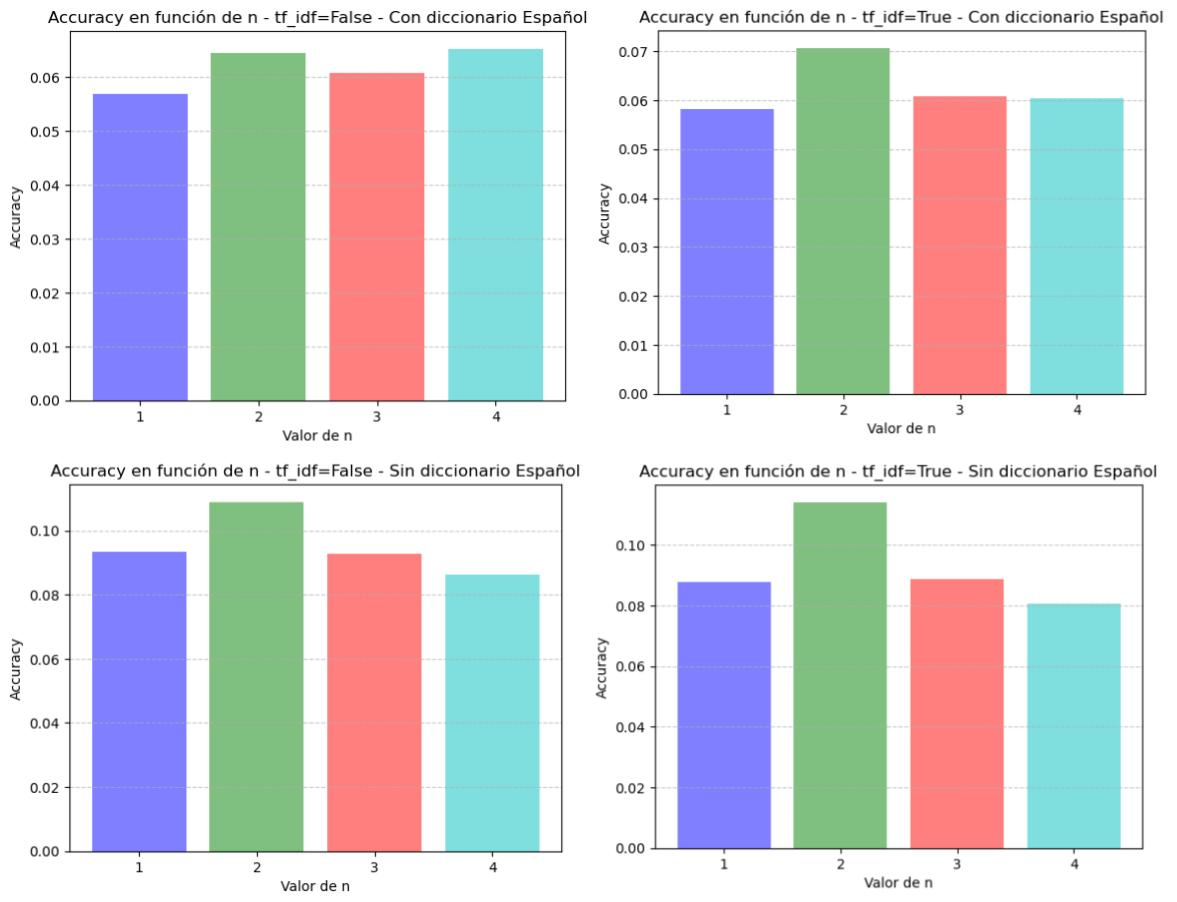


### 3.1.2 Selección del hiperparámetro N

Entendemos que el lenguaje en el grupo de amigos no es el mismo que se utiliza en un grupo laboral. Por tal motivo, se decidió dividir el corpus en un conjunto de entrenamiento y un conjunto de validación, con un porcentaje de 80/20, respectivamente. De esta forma, nos aseguramos de que tanto en nuestro conjunto de entrenamiento como en el de validación utilice el mismo lenguaje. Debido a que en este caso no podemos utilizar el corpus de validación directamente, se le aplica la función `creacion_de_conjunto_de_test` para obtener los conjuntos `X_val` e `y_val`, de la misma manera en que se hizo para las pruebas de tf-idf.
Una vez que se obtuvo un conjunto de datos utlizables para validar, se aplica el siguinete código.

```python
viol = []
n_values = [1, 2, 3, 4]

for i in n_values:
    n = i
    modelo = Predictor_Naive_Bayes()
    modelo.entrenar_naive_bayes(corpus_entrenamiento, n, tf_idf=True)
    X_val, y_val = creacion_de_conjunto_de_test(corpus_validacion, n)
    y_pred_val = []
    for j in range(len(X_val)):
        h_MAP, p_MAP = modelo.predecir(X_val[j])
        y_pred_val.append([h_MAP])
    acc = get_accuracy(y_val, y_pred_val)
    viol.append(acc)
    print("acc:", acc, "hiperparámetro n=", n)
```
Este código entrena y evalua el clasificador con diferentes valores de 'n' en un conjunto de datos de entrenamiento y validación, y registra los accuracy en la lista 'viol' para su posterior análisis."

Para el análisis, se realizó la Gráfica 2: Accuracy en función de N - tf_idf=True - Sin diccionario Español. En ella se observa que el mejor rendimiento del modelo se alcanza cuando se le asigna un valor de N = 2, y luego comienza a degradarse a medida que el valor de N aumenta.



In [7]:
#Divide el corpus en corpus_entrenamiento, corpus_validacion
corpus_entrenamiento, corpus_validacion = train_test_split(corpus,   test_size=0.2, shuffle=True, random_state=42)
modelo = Predictor_Naive_Bayes()

In [8]:
#Prueba el rendimiento según el valor del hiperparámtro N
viol = []
n_values = [1, 2, 3, 4, 5, 6]

for i in n_values:
    n = i
    modelo = Predictor_Naive_Bayes()
    modelo.entrenar_naive_bayes(corpus_entrenamiento, n, tf_idf=True)
    X_val, y_val = creacion_de_conjunto_de_test(corpus_validacion, n)
    y_pred_val = []
    for j in range(len(X_val)):
        h_MAP, p_MAP = modelo.predecir(X_val[j])
        y_pred_val.append([h_MAP])
    acc = get_accuracy(y_val, y_pred_val)
    viol.append(acc)
    print("acc:", acc, "hiperparámetro n=", n)


acc: 0.09673202614379085 hiperparámetro n= 1
acc: 0.10128617363344052 hiperparámetro n= 2
acc: 0.08372404554588078 hiperparámetro n= 3
acc: 0.07795473595976529 hiperparámetro n= 4
acc: 0.07596253902185224 hiperparámetro n= 5
acc: 0.06306306306306306 hiperparámetro n= 6


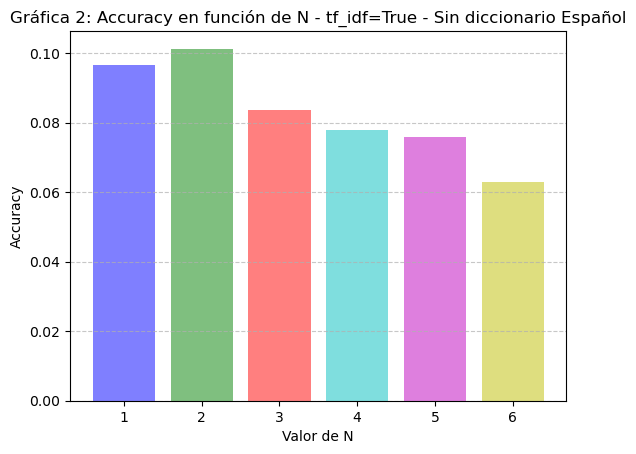

In [9]:

colors = ['b', 'g', 'r', 'c', 'm', 'y']
plt.bar(n_values, viol, align='center', alpha=0.5 , color=colors)
plt.xlabel('Valor de N')
plt.ylabel('Accuracy')
plt.title('Gráfica 2: Accuracy en función de N - tf_idf=True - Sin diccionario Español')
plt.xticks(n_values)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

## 3.2 Pruebas con simulador de cliente

Hasta este punto, nuestras pruebas se han enfocado principalmente en medir el rendimiento del modelo, sin dar prioridad a la experiencia de usuario. Con el objetivo de evaluar la experiencia de usuario, empleamos el código proporcionado por el profesor y lo adaptamos para implementar nuestro modelo de predicción.
Durante el proceso de pruebas, ingresamos frases que pertenecían originalmente al conjunto de entrenamiento del modelo, así como frases que no habían sido utilizadas en el entrenamiento. Esto nos permitió confirmar que el modelo tiene una mejor capacidad predictiva cuando se enfrenta a frases que habían sido parte del entrenamiento.

Otro aspecto que debíamos analizar en esta etapa es el tiempo requerido para predecir una palabra y el tiempo necesario para volver a entrenar el modelo cuando se introduce una frase nueva en una interfaz interactiva. Con el corpus utilizado, los tiempos obtenidos para la predicción son casi imperceptibles, pero el tiempo requerido para el reentrenamiento es demasiado elevado para ser realizado de manera interactiva.

In [10]:
#Entrenamiento de modelo
n=2
modelo = Predictor_Naive_Bayes()
modelo.entrenar_naive_bayes(corpus, n , tf_idf=True)


In [12]:
def recomendacion_bayesiana(frase):
  frase_completa = ' '.join(frase)
  return(modelo.obtener_palabra(frase_completa))


##### LOOP PRINCIPAL #####

print("Ingrese la frase dando ENTER luego de \x1b[3mcada palabra\x1b[0m.")
print("Ingrese sólo ENTER para aceptar la recomendación sugerida, o escriba la siguiente palabra y de ENTER")
print("Ingrese '.' para comenzar con una frase nueva.")
print("Ingrese '..' para terminar el proceso.")

frase = []
palabra_sugerida = ""
while 1:
    palabra = input(">> ")

    if palabra == "..":
      break

    elif palabra == ".":
      print("----- Comenzando frase nueva -----")
      frase_completa = ' '.join(frase)
      modelo.reentrenar(frase_completa, True ) #Reentrena con frase ingresada
      frase = []

    elif palabra == "": # acepta última palabra sugerida
      frase.append(palabra_sugerida)

    else: # escribió una palabra
      frase.append(palabra)

    if frase:
      palabra_sugerida = recomendacion_bayesiana(frase)
      print("palabra_sugerida" ,  palabra_sugerida)
      frase_propuesta = frase.copy()
      frase_propuesta.append("\x1b[3m"+ palabra_sugerida +"\x1b[0m")

      print(" ".join(frase_propuesta))

Ingrese la frase dando ENTER luego de cada palabra.
Ingrese sólo ENTER para aceptar la recomendación sugerida, o escriba la siguiente palabra y de ENTER
Ingrese '.' para comenzar con una frase nueva.
Ingrese '..' para terminar el proceso.
>> hola
palabra_sugerida amoras
hola amoras
>> 
palabra_sugerida como
hola amoras como
>> 
palabra_sugerida están
hola amoras como están
>> 
palabra_sugerida las
hola amoras como están las
>> .
----- Comenzando frase nueva -----
>> hola prima
palabra_sugerida como
hola prima como
>> 
palabra_sugerida que
hola prima como que
>> estás
palabra_sugerida con
hola prima como estás con
>> .
----- Comenzando frase nueva -----
>> mañana vamos
palabra_sugerida a
mañana vamos a
>> 
palabra_sugerida las
mañana vamos a las
>> la
palabra_sugerida de
mañana vamos a la de
>> plaza
palabra_sugerida de
mañana vamos a la plaza de
>> .
----- Comenzando frase nueva -----
>> nosotras estamos
palabra_sugerida en
nosotras estamos en
>> 
palabra_sugerida el
nosotras estamos e

# 4. Conclusión

Consideramos que la división del corpus en entrenamiento y test, junto con la definición de los conjuntos de validación (`X_val` e  `y_val`) para determinar el accuracy de nuestro modelo fue una decisión adecuada, ya que nos proporcionó una forma de comparar las diferentes pruebas realizadas, que de usar las probabilidades no sería posible la comparación directa.

Fue posible observar una mejora en el accuracy del modelo cuando se utiliza `tf_idf` para las probabilidades a priori de las clases. Esto era un resultado esperado, ya que esta forma considera la importancia de las palabras en todo el corpus.

El tamaño del corpus afecta directamente el tiempo de entrenamiento, y esto es una dificultad real a la hora de re-entrenar con las frases nuevas, ya que aumenta el tiempo entre las predicciones.

Se pudo observar que al cruzar el corpus con el diccionario español, el algoritmo tiende a predecir palabras comunes, como conjunciones y artículos (‘la’, ‘de’, etc.). Para algunos usuarios puede ser deseable que el algoritmo prediga palabras que no necesariamente están correctas en español, ya que el uso de modismos es común en los chat de redes sociales.

Algunas mejoras a futuro a implementar en el algoritmo pueden ser: probar con otro diccionario que sea específico de español, ya que el `nltk` está optimizado para inglés; estudiar formas de mejorar los tiempos de re-entrenamiento del algoritmo.





# Bibliografía

Mitchell, T.(1997). Machine Learning. Publisher: McGraw Hill.
